# Region masks

POP includes a default region mask as a component of the grid information. This is often not super 
relevant for analyses. `pop_tools` provides several alternative region masks; these are demostrated here.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pop_tools

## Load POP grid as `xarray.Dataset`

In [2]:
grid_name = 'POP_gx1v7'

ds = pop_tools.get_grid(grid_name)
ds

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA        (nlat, nlon) float64 1.39e+13 1.39e+13 ... 7.431e+12 7.432e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0

## Plot default `REGION_MASK`
The default `REGION_MASK` is a 2-D array with unique integer values for each region. Negative integers denote "marginal seas," which are not directly connected to the ocean.

In [3]:
regions = np.array(np.unique(ds.REGION_MASK))
regions

array([-13, -12,  -5,   0,   1,   2,   3,   4,   6,   7,   8,   9,  10,
        11], dtype=int32)

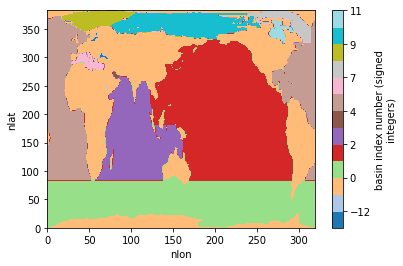

In [4]:
ds.REGION_MASK.plot.contourf(levels=regions, cmap='tab20');

## More useful region masks

It's often more useful to define a region mask as a 3-D array of zeros and ones, where the first dimension is `region`; this permits overlapping regions and is convenient for computation because the mask can be applied by multiplication, which yields a `region` dimension via broadcasting.

`pop_tools` supports converting the default `REGION_MASK` to this type of mask thru the `region_mask_3d` function.

In [5]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask3d

<xarray.DataArray (region: 13, nlat: 384, nlon: 320)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
Dimensions without coordinates: nlat, nlon
Attributes:
    mask_name:  default

This mask includes a coordinate variable with the region names.

In [6]:
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

A particular region can be selected by name.

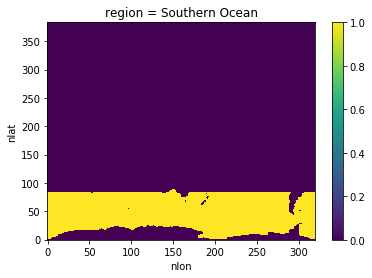

In [7]:
mask3d.sel(region='Southern Ocean').plot();

To visualize all the regions, we can define a help plotting function,

In [8]:
def visualize_mask(mask3d):
    nregion = len(mask3d.region)

    # mask out land
    mask3d = mask3d.where(ds.KMT > 0)

    # visualize the regions
    ncol = int(np.sqrt(nregion))
    nrow = int(nregion/ncol) + min(1, nregion%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), 
                           constrained_layout=True)

    for i, region in enumerate(mask3d.region.values):
        plt.axes(ax.ravel()[i])
        mask3d.sel(region=region).plot()

    # delete the unused axes
    for i in range(nregion, ncol*nrow):
        fig.delaxes(ax.ravel()[i])
    
    fig.suptitle(f'Mask name = {mask3d.mask_name}', fontsize=16)

and apply it to the default mask created above.

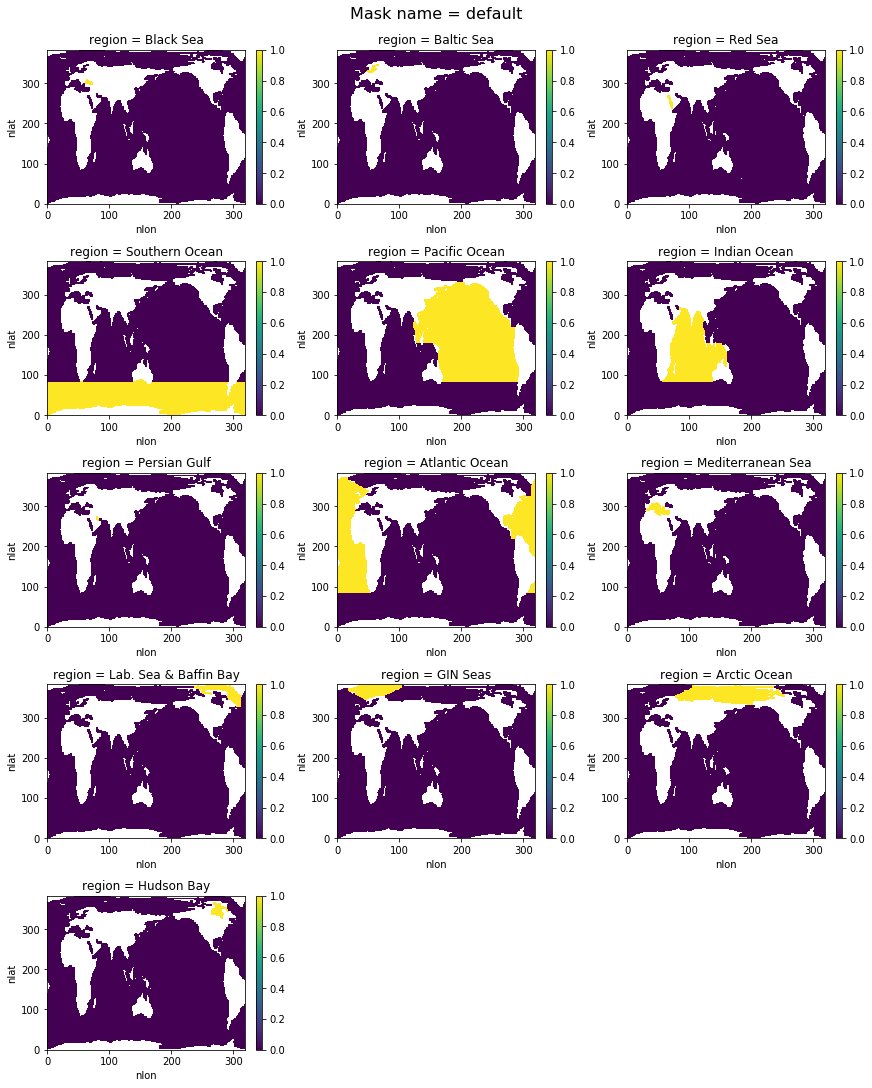

In [9]:
visualize_mask(mask3d)

## Alternative region masks

Other useful region masks are pre-defined in the package. `list_region_masks` returns a list of pre-defined masks.

In [10]:
region_masks = pop_tools.list_region_masks(grid_name)
region_masks

['lat-range-basin', 'Pacific-Indian-Atlantic']

We can visualize all of these using the helper function above.

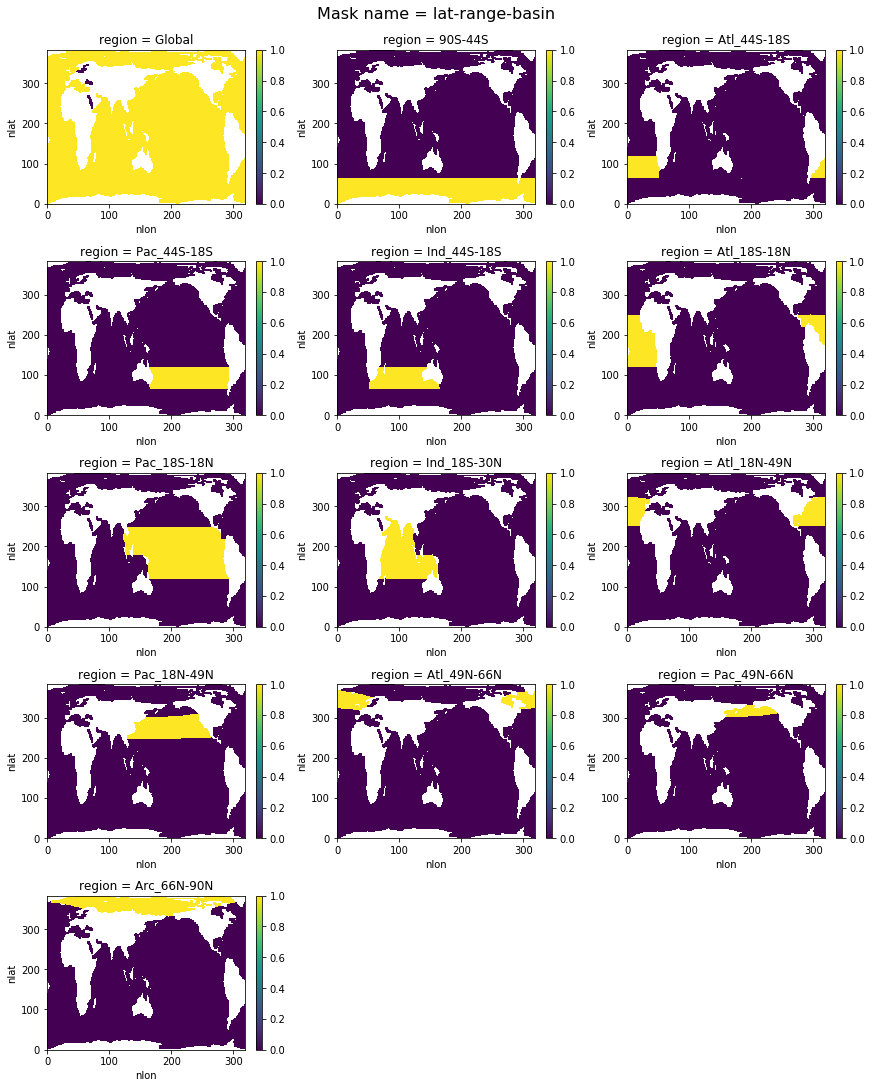

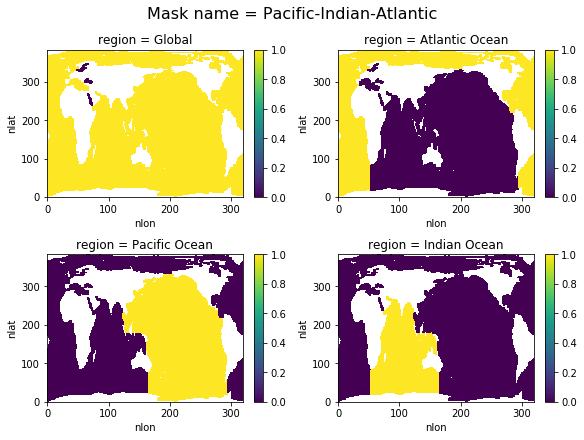

In [11]:
for region_mask in region_masks:
    mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)
    visualize_mask(mask3d)

To illustrated how regions cover the global domain, including with overlap, we can sum over the `region` dimension. 

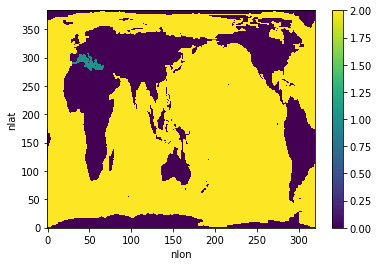

In [12]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='lat-range-basin')
mask3d.sum('region').plot();

## User defined region masks

Finally, it is also possible to make a region mask on the fly by building a dictionary containing the defining logic. `region_mask_3d` accepts a `region_defs` argument. This is a dictionary of the following form.

```python
region_defs = {region1_name: list_of_criteria_dicts_1, 
               region2_name: list_of_criteria_dicts_2,...}
```

The `list_of_criteria_dicts` are lists of dictionaries; each must include the keys 'match' or 'bounds'. For instance:

```python
list_of_criteria_dicts_1 = [{'match': {'REGION_MASK': [1, 2, 3, 6]}, 
                             'bounds': {'TLAT': [-90., -30.]}}]
```
will return a mask where the default `REGION_MASK` matches the specified values and `TLAT` falls between the specified bounds. Multiple entries in the `list_of_criteria_dicts` are applied with an "or" condition.

Here's an example region mask generated for the North Atlantic Subpolar and Subtropical Gyres.

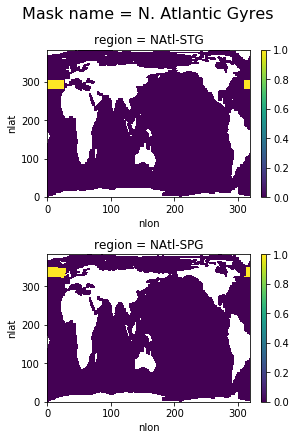

In [13]:
region_defs = {'NAtl-STG': [{'match': 
                             {'REGION_MASK': [6]},
                            'bounds': 
                             {'TLAT': [32., 42.], 'TLONG': [310., 350.]}}],
              'NAtl-SPG':  [{'match': 
                             {'REGION_MASK': [6]},
                            'bounds': 
                             {'TLAT': [50., 60.], 'TLONG': [310., 350.]}}],}

mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, 
                                  mask_name='N. Atlantic Gyres')
visualize_mask(mask3d)